In [1]:
from collections import Counter, defaultdict
from typing import List, Dict, Literal, Union
import re
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import warnings

warnings.filterwarnings('ignore')
CACHE_DIR = './cache'

READ DATA AND BASIC EXPLORE

In [2]:
dataset = load_dataset('UniverseTBD/arxiv-abstracts-large', cache_dir=CACHE_DIR)
dataset

README.md:   0%|          | 0.00/810 [00:00<?, ?B/s]

arxiv-metadata-oai-snapshot.json:   0%|          | 0.00/3.82G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2292057 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed'],
        num_rows: 2292057
    })
})

In [3]:
for i in range(3):
  print(f'Example {i + 1}:')
  print(dataset['train'][i]['abstract'])
  print(dataset['train'][i]['categories'])
  print('---'*20)

Example 1:
  A fully differential calculation in perturbative quantum chromodynamics is
presented for the production of massive photon pairs at hadron colliders. All
next-to-leading order perturbative contributions from quark-antiquark,
gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as
all-orders resummation of initial-state gluon radiation valid at
next-to-next-to-leading logarithmic accuracy. The region of phase space is
specified in which the calculation is most reliable. Good agreement is
demonstrated with data from the Fermilab Tevatron, and predictions are made for
more detailed tests with CDF and DO data. Predictions are shown for
distributions of diphoton pairs produced at the energy of the Large Hadron
Collider (LHC). Distributions of the diphoton pairs from the decay of a Higgs
boson are contrasted with those produced from QCD processes at the LHC, showing
that enhanced sensitivity to the signal can be obtained with judicious
selection of events.

hep-p

In [4]:
all_categories = dataset['train']['categories']
print(set(all_categories))

{'nlin.SI cs.LG nlin.PS physics.class-ph', 'stat.AP math.NA q-bio.QM', 'q-bio.MN q-bio.BM q-bio.QM q-bio.SC', 'cs.CV cs.AI cs.CL cs.LG eess.AS', 'cs.PL cs.CL cs.IR', 'cond-mat.str-el cond-mat.quant-gas hep-ph', 'adap-org cond-mat nlin.AO q-bio', 'hep-lat cond-mat.stat-mech nucl-th quant-ph', 'cs.DM cs.CG cs.RO', 'stat.OT hep-ex physics.data-an', 'physics.med-ph physics.flu-dyn physics.soc-ph', 'hep-ex astro-ph nucl-ex physics.geo-ph', 'stat.ME cs.NA math.NA math.OC math.ST physics.data-an stat.TH', 'nlin.CD cond-mat.dis-nn nlin.AO', 'eess.SP physics.data-an physics.flu-dyn stat.ML', 'cs.CG nlin.PS', 'physics.med-ph cs.RO q-bio.NC', 'math.OA math.QA math.SP', 'cs.CE cs.LG physics.chem-ph', 'cs.NE cs.CE', 'physics.class-ph nlin.CD physics.plasm-ph', 'cond-mat.soft cond-mat.stat-mech q-bio.GN', 'stat.AP q-bio.GN q-bio.PE stat.CO', 'cs.SI cs.GT physics.soc-ph', 'math.OC cs.CV cs.DM stat.ML', 'eess.AS cs.HC', 'cs.AI cs.DB physics.soc-ph', 'math.CO math-ph math.AG math.KT math.MP math.RT', '

In [5]:
categories_set = set()

for cat in all_categories:
  part = cat.split(' ')
  for p in part:
    topic = p.split('.')[0]
    categories_set.add(topic)

sorted_categories = sorted(list(categories_set), key=lambda x: x.lower())
print(f'There are {len(sorted_categories)} unique primary categories in dataset: ')
for category in sorted_categories:
  print(category)

There are 38 unique primary categories in dataset: 
acc-phys
adap-org
alg-geom
ao-sci
astro-ph
atom-ph
bayes-an
chao-dyn
chem-ph
cmp-lg
comp-gas
cond-mat
cs
dg-ga
econ
eess
funct-an
gr-qc
hep-ex
hep-lat
hep-ph
hep-th
math
math-ph
mtrl-th
nlin
nucl-ex
nucl-th
patt-sol
physics
plasm-ph
q-alg
q-bio
q-fin
quant-ph
solv-int
stat
supr-con


In [6]:
samples = []
CATEGORIES_TO_SELECT = ['astro-ph', 'cond-mat', 'cs', 'math', 'physics']
for s in dataset['train']:
  if len(s['categories'].split(' ')) != 1:
    continue

  cur_category = s['categories'].strip().split('.')[0]
  if cur_category not in CATEGORIES_TO_SELECT:
    continue

  samples.append(s)
  if len(samples) >= 1000: break

print(f'Number of samples: {len(samples)}')

for sample in samples[:3]:
    print(f"Category: {sample['categories']}")
    print("Abstract:", sample['abstract'])
    print("#" * 20 + "\n")

Number of samples: 1000
Category: physics.gen-ph
Abstract:   The evolution of Earth-Moon system is described by the dark matter field
fluid model proposed in the Meeting of Division of Particle and Field 2004,
American Physical Society. The current behavior of the Earth-Moon system agrees
with this model very well and the general pattern of the evolution of the
Moon-Earth system described by this model agrees with geological and fossil
evidence. The closest distance of the Moon to Earth was about 259000 km at 4.5
billion years ago, which is far beyond the Roche's limit. The result suggests
that the tidal friction may not be the primary cause for the evolution of the
Earth-Moon system. The average dark matter field fluid constant derived from
Earth-Moon system data is 4.39 x 10^(-22) s^(-1)m^(-1). This model predicts
that the Mars's rotation is also slowing with the angular acceleration rate
about -4.38 x 10^(-22) rad s^(-2).

####################

Category: math.CO
Abstract:   We show 

DATA PREPROCESSING

In [7]:
preprocessed_samples = []
for s in samples:
  abstract = s['abstract']
  abstract = abstract.strip().replace('\n', ' ')
  abstract = re.sub(r'[^\w\s]', '', abstract)
  abstract = re.sub(r'\d+', '', abstract)
  abstract = re.sub(r'\s+', ' ', abstract).strip()
  abstract = abstract.lower()
  part = s['categories'].split(' ')
  category = part[0].split('.')[0]

  preprocessed_samples.append({
      'text': abstract,
      'label': category
  })

  for sample in preprocessed_samples[:3]:
    print(f"Label: {sample['label']}")
    print("Text:", sample['text'])
    print("#" * 20 + "\n")

Label: physics
Text: the evolution of earthmoon system is described by the dark matter field fluid model proposed in the meeting of division of particle and field american physical society the current behavior of the earthmoon system agrees with this model very well and the general pattern of the evolution of the moonearth system described by this model agrees with geological and fossil evidence the closest distance of the moon to earth was about km at billion years ago which is far beyond the roches limit the result suggests that the tidal friction may not be the primary cause for the evolution of the earthmoon system the average dark matter field fluid constant derived from earthmoon system data is x sm this model predicts that the marss rotation is also slowing with the angular acceleration rate about x rad s
####################

Label: physics
Text: the evolution of earthmoon system is described by the dark matter field fluid model proposed in the meeting of division of particle a

In [8]:
labels = set([s['label'] for s in preprocessed_samples])
# Sort and print unique labels
sorted_labels = sorted(labels)
for label in sorted_labels:
    print(label)

astro-ph
cond-mat
cs
math
physics


In [9]:
label_to_id = {label: i for i, label in enumerate(sorted_categories)}
id_to_label = {i: label for i, label in enumerate(sorted_categories)}

print('Label to ID mapping: ')
for label, id_ in label_to_id.items():
  print(f'{label}: {id_}')

Label to ID mapping: 
acc-phys: 0
adap-org: 1
alg-geom: 2
ao-sci: 3
astro-ph: 4
atom-ph: 5
bayes-an: 6
chao-dyn: 7
chem-ph: 8
cmp-lg: 9
comp-gas: 10
cond-mat: 11
cs: 12
dg-ga: 13
econ: 14
eess: 15
funct-an: 16
gr-qc: 17
hep-ex: 18
hep-lat: 19
hep-ph: 20
hep-th: 21
math: 22
math-ph: 23
mtrl-th: 24
nlin: 25
nucl-ex: 26
nucl-th: 27
patt-sol: 28
physics: 29
plasm-ph: 30
q-alg: 31
q-bio: 32
q-fin: 33
quant-ph: 34
solv-int: 35
stat: 36
supr-con: 37


In [10]:
x_full = [sample['text'] for sample in preprocessed_samples]
y_full = [label_to_id[sample['label']] for sample in preprocessed_samples]

xtrain, xtest, ytrain, ytest = train_test_split(x_full, y_full, test_size=0.2, random_state=42, stratify=y_full)

print(f'Training set: {len(xtrain)}')
print(f'Testing set: {len(xtest)}')

Training set: 800
Testing set: 200


BoW FOR TEXT ENCODER

In [11]:
test_docs = [
    "I am going to school to study for the final exam.",
    "The weather is nice today and I feel happy.",
    "I love programming in Python and exploring new libraries.",
    "Data science is an exciting field with many opportunities.",
]

In [12]:
bow = CountVectorizer()
vectors = bow.fit_transform(test_docs)

for i, vec in enumerate(vectors):
  print(f'Document {i + 1}: {vec.toarray()}')

Document 1: [[1 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 2 0 0 0]]
Document 2: [[0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0]]
Document 3: [[0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0]]
Document 4: [[0 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1]]


TF-IDF FOR TEXT ENCODER

In [13]:
vectorizer = TfidfVectorizer()
tfidf_vector = vectorizer.fit_transform(test_docs)

for i, vec in enumerate(tfidf_vector):
  print(f'Document {i + 1}: {vec.toarray()}')

Document 1: [[0.29333722 0.         0.         0.         0.29333722 0.
  0.         0.         0.         0.29333722 0.29333722 0.29333722
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.29333722
  0.         0.29333722 0.23127044 0.58667444 0.         0.
  0.        ]]
Document 2: [[0.         0.         0.30091213 0.         0.         0.
  0.         0.38166888 0.         0.         0.         0.
  0.38166888 0.         0.30091213 0.         0.         0.
  0.         0.38166888 0.         0.         0.         0.
  0.         0.         0.30091213 0.         0.38166888 0.38166888
  0.        ]]
Document 3: [[0.         0.         0.2855815  0.         0.         0.
  0.36222393 0.         0.         0.         0.         0.
  0.         0.36222393 0.         0.36222393 0.36222393 0.
  0.36222393 0.         0.         0.36222393 0.36222393 0.
  0.         0.         0.         0.         0.         0.
  0.      

SENTENCE EMBEDDINGS FOR TEXT ENCODER

In [14]:
class EmbeddingVectorizer:
  def __init__(self, model_name: str = 'intfloat/multilingual-e5-base', normalize: bool = True):
    self.model = SentenceTransformer(model_name)
    self.normalize = normalize

  def _format_inputs(self, texts: List[str], mode: Literal['query', 'passage']) -> List[str]:
    if mode not in {'query', 'passage'}:
      raise ValueError('Mode must be either query or passage')

    return [f'{mode}: {text.strip()}' for text in texts]

  def transform(self, texts: List[str], mode: Literal['query', 'passage'] = 'query') -> List[List[float]]:
    if mode == 'raw':
      inputs = texts
    else:
      inputs = self._format_inputs(texts, mode)

    embeddings = self.model.encode(inputs, normalize_embeddings=self.normalize)
    return embeddings.tolist()

  def transform_numpy(self, texts: List[str], mode: Literal['query', 'passage'] = 'query') -> np.ndarray:
    return np.array(self.transform(texts, mode=mode))

In [15]:
vector_embedding = EmbeddingVectorizer()
embedding = vector_embedding.transform(test_docs)

for i, emb in enumerate(embedding):
  print(f'Document {i + 1}: {emb[:3]}')

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

Document 1: [-0.014805685728788376, 0.031276602298021317, -0.01615864969789982]
Document 2: [0.01191739086061716, 0.03327367454767227, -0.025738948956131935]
Document 3: [0.012662852182984352, 0.039361219853162766, -0.024181142449378967]
Document 4: [0.0063935876823961735, 0.04922204092144966, -0.02840282768011093]


In [16]:
bow_vectorizer = CountVectorizer()
xtrain_bow = bow_vectorizer.fit_transform(xtrain)
xtest_bow = bow_vectorizer.transform(xtest)

xtrain_bow, xtest_bow = np.array(xtrain_bow.toarray()), np.array(xtest_bow.toarray())

print(f'Shape of bow: {xtrain_bow.shape}, {xtest_bow.shape}')

Shape of bow: (800, 10373), (200, 10373)


In [17]:
tfidf_vectorizer = TfidfVectorizer()
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xtest_tfidf = tfidf_vectorizer.transform(xtest)

xtrain_tfidf, xtest_tfidf = np.array(xtrain_tfidf.toarray()), np.array(xtest_tfidf.toarray())

print(f'Shape of tfidf: {xtrain_tfidf.shape}, {xtest_tfidf.shape}')

Shape of tfidf: (800, 10373), (200, 10373)


In [18]:
embeddings_vectorizer = EmbeddingVectorizer()
xtrain_embeddings = embeddings_vectorizer.transform(xtrain)
xtest_embeddings = embeddings_vectorizer.transform(xtest)

xtrain_embeddings, xtest_embeddings = np.array(xtrain_embeddings), np.array(xtest_embeddings)

print(f'Shape of embeddings: {xtrain_embeddings.shape}, {xtest_embeddings.shape}')

Shape of embeddings: (800, 768), (200, 768)


TRAINING MODEL: KMEANS

In [19]:
def train_and_test_kmeans(xtrain, ytrain, xtest, ytest):
    # Determine the number of clusters based on the unique labels in the training data
    n_cluster = len(set(ytrain))
    kmeans = KMeans(n_clusters=n_cluster, random_state=42, n_init=10)
    cluster_ids = kmeans.fit_predict(xtrain)

    cluster_to_label = {}
    for cluster_id in set(cluster_ids):
        labels_in_cluster = [ytrain[i] for i in range(len(ytrain)) if cluster_ids[i] == cluster_id]
        # Use the most common label in the cluster
        most_common_label = Counter(labels_in_cluster).most_common(1)[0][0]
        cluster_to_label[cluster_id] = most_common_label

    test_cluster_ids = kmeans.predict(xtest)
    ypred = [cluster_to_label[cluster_id] for cluster_id in test_cluster_ids]
    accuracy = accuracy_score(ytest, ypred)

    # Get unique labels from both ytest and ypred to ensure all present labels are covered
    unique_labels = sorted(list(set(ytest + ypred)))

    # Filter target_names based on unique_labels using the global id_to_label mapping
    target_names_filtered = [id_to_label[i] for i in unique_labels]

    report = classification_report(ytest, ypred, labels=unique_labels, target_names=target_names_filtered, output_dict=True)

    return ypred, accuracy, report

In [20]:
km_bow_labels, km_bow_accuracy, km_bow_report = train_and_test_kmeans(
    xtrain_bow, ytrain, xtest_bow, ytest)
km_tfidf_labels, km_tfidf_accuracy, km_tfidf_report = train_and_test_kmeans(
    xtrain_tfidf, ytrain, xtest_tfidf, ytest)
km_embeddings_labels, km_embeddings_accuracy, km_embeddings_report = train_and_test_kmeans(
    xtrain_embeddings, ytrain, xtest_embeddings, ytest)

print(f'Accuracy kmeans for bag of words: {km_bow_accuracy}')
print(f'Accuracy kmeans for tfidf: {km_tfidf_accuracy}')
print(f'Accuracy kmeans for embeddings: {km_embeddings_accuracy}')

Accuracy kmeans for bag of words: 0.56
Accuracy kmeans for tfidf: 0.71
Accuracy kmeans for embeddings: 0.855


In [36]:
def plot_confusion_matrix(ytrue, ypred, label_mapping, figure_name='Confusion Matrix', save_path=None):
    # Chuẩn hóa nhãn về 1D array int
    ytrue = np.asarray(ytrue).astype(int).ravel()
    ypred = np.asarray(ypred).astype(int).ravel()

    # Chuẩn hóa mapping: khóa int
    label_mapping_int = {int(k): v for k, v in label_mapping.items()}

    # Tập nhãn xuất hiện
    classes = np.unique(np.concatenate([ytrue, ypred])).astype(int)

    # Tạo ma trận với thứ tự nhãn cố định
    cm = confusion_matrix(ytrue, ypred, labels=classes)

    # Chuẩn hóa theo hàng, tránh chia cho 0
    row_sums = cm.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    cm_normalized = cm / row_sums

    # Tên lớp (fallback nếu thiếu trong mapping)
    class_names = [label_mapping_int.get(c, f"UNK_{c}") for c in classes]

    # Annotations "raw\n(%)"
    annotations = np.empty_like(cm, dtype=object)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annotations[i, j] = f"{cm[i, j]}\n({cm_normalized[i, j]:.2%})"

    plt.figure(figsize=(max(6, 0.9*len(classes)), max(4, 0.9*len(classes))))
    sns.heatmap(
        cm,
        annot=annotations,
        fmt='',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=False,
        linewidths=1,
        linecolor='black'
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(figure_name)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

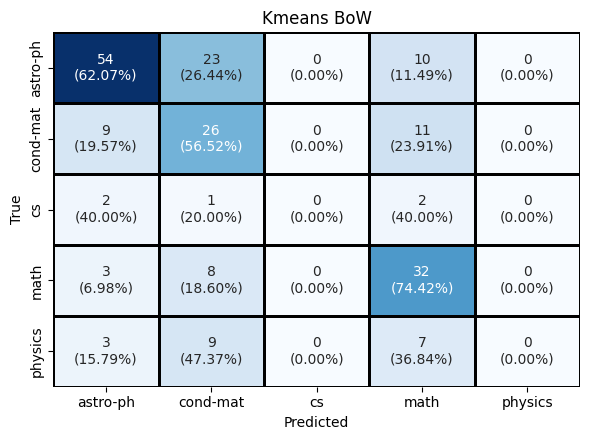

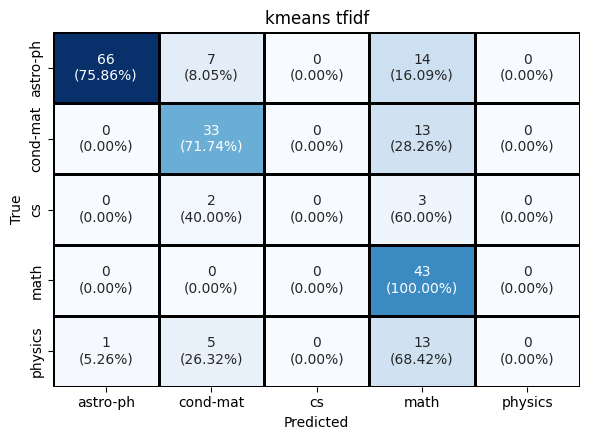

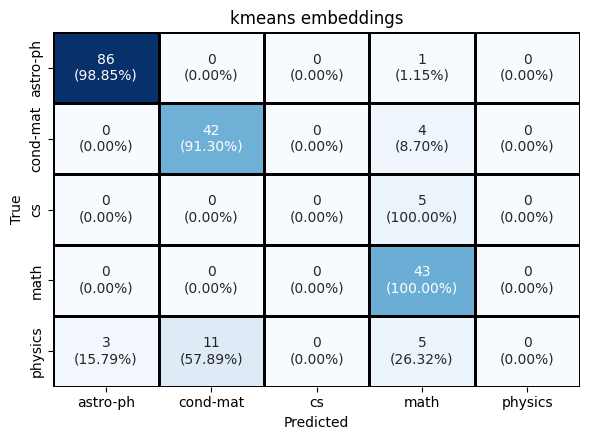

In [37]:
plot_confusion_matrix(ytest, km_bow_labels, id_to_label, 'Kmeans BoW')
plot_confusion_matrix(ytest, km_tfidf_labels, id_to_label, 'kmeans tfidf')
plot_confusion_matrix(ytest, km_embeddings_labels, id_to_label, 'kmeans embeddings')

TRAINING MODEL: KNN

In [34]:
def train_and_test_knn(xtrain, ytrain, xtest, ytest, n_neighbors: int = 5):
  knn = KNeighborsClassifier(n_neighbors=n_neighbors)
  knn.fit(xtrain, ytrain)

  ypred = knn.predict(xtest)

  accuracy = accuracy_score(ypred, ytest)
  report = classification_report(ytest, ypred, target_names=sorted_labels, output_dict=True)

  return ypred, accuracy, report

In [24]:
knn_bow_labels, knn_bow_accuracy, knn_bow_report = train_and_test_knn(xtrain_bow, ytrain, xtest_bow, ytest)
knn_tfidf_labels, knn_tfidf_accuracy, knn_tfidf_report = train_and_test_knn(xtrain_tfidf, ytrain, xtest_tfidf, ytest)
knn_embeddings_labels, knn_embeddings_accuracy, knn_embeddings_report = train_and_test_knn(xtrain_embeddings, ytrain, xtest_embeddings, ytest)

print('Accuracy of KNN')
print(f'BoW: {knn_bow_accuracy:.4f}')
print(f'TF-IDF; {knn_tfidf_accuracy:.4f}')
print(f'Embeddings: {knn_embeddings_accuracy:.4f}')

Accuracy of KNN
BoW: 0.5300
TF-IDF; 0.8150
Embeddings: 0.8900


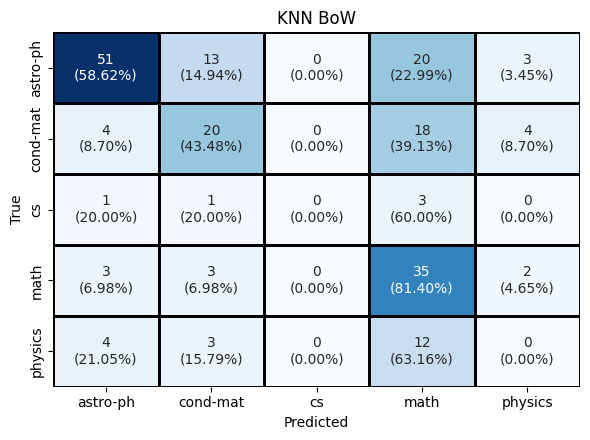

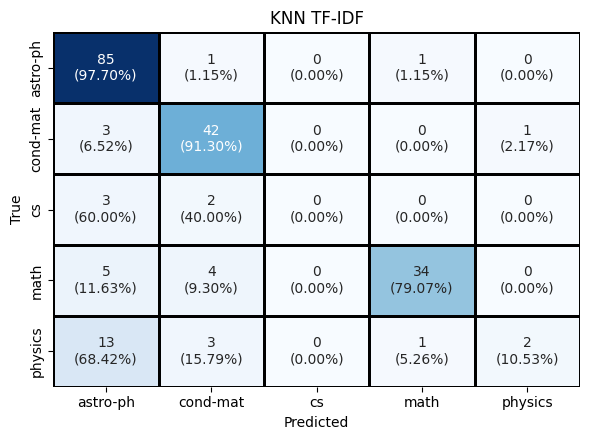

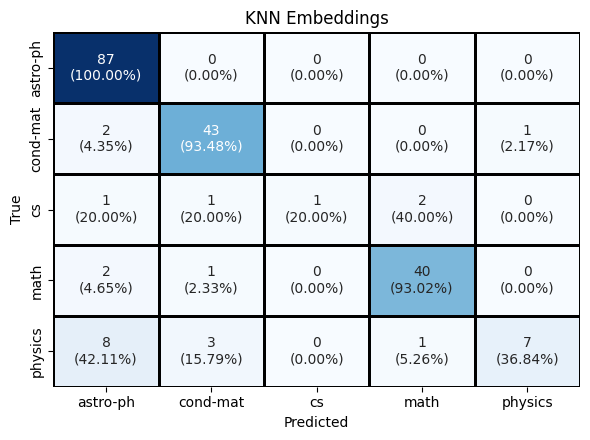

In [38]:
plot_confusion_matrix(ytest, knn_bow_labels, id_to_label, 'KNN BoW')
plot_confusion_matrix(ytest, knn_tfidf_labels, id_to_label, 'KNN TF-IDF')
plot_confusion_matrix(ytest, knn_embeddings_labels, id_to_label, 'KNN Embeddings')

TRAINING MODEL: DECISION TREE

In [40]:
def train_and_test_decisiontree(xtrain, ytrain, xtest, ytest):
  dt = DecisionTreeClassifier()
  dt.fit(xtrain, ytrain)

  ypred = dt.predict(xtest)

  accuracy = accuracy_score(ytest, ypred)
  report = classification_report(ytest, ypred, target_names=sorted_labels, output_dict=True)

  return ypred, accuracy, report

In [41]:
dt_bow_labels, dt_bow_accuracy, dt_bow_report = train_and_test_decisiontree(xtrain_bow, ytrain, xtest_bow, ytest)
dt_tfidf_labels, dt_tfidf_accuracy, dt_tfidf_report = train_and_test_decisiontree(xtrain_tfidf, ytrain, xtest_tfidf, ytest)
dt_embeddings_labels, dt_embeddings_accuracy, dt_embeddings_report = train_and_test_decisiontree(xtrain_embeddings, ytrain, xtest_embeddings, ytest)

print('Accuracy of Decision Tree')
print(f'Bow: {dt_bow_accuracy:.4f}')
print(f'Tf-idf: {dt_tfidf_accuracy:.4f}')
print(f'Embeddings: {dt_embeddings_accuracy:.4f}')

Accuracy of Decision Tree
Bow: 0.6250
Tf-idf: 0.6250
Embeddings: 0.6750


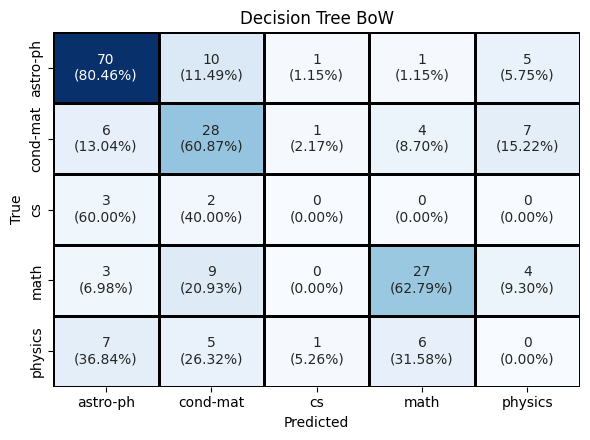

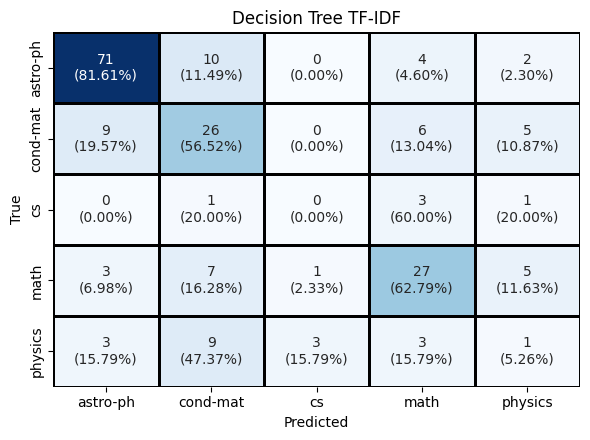

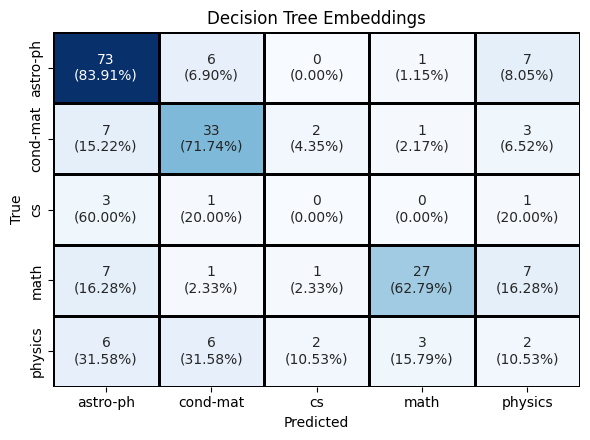

In [42]:
plot_confusion_matrix(ytest, dt_bow_labels, id_to_label, 'Decision Tree BoW')
plot_confusion_matrix(ytest, dt_tfidf_labels, id_to_label, 'Decision Tree TF-IDF')
plot_confusion_matrix(ytest, dt_embeddings_labels, id_to_label, 'Decision Tree Embeddings')

TRAINING MODEL: NAIVE BAYES

In [43]:
def train_and_test_naivebayes(xtrain, ytrain, xtest, ytest):
  nb = GaussianNB()

  xtrain_dense = xtrain.toarray() if hasattr(xtrain, 'toarray') else xtrain
  xtest_dense = xtest.toarray() if hasattr(xtest, 'toarray') else xtest

  ypred = nb.fit(xtrain_dense, ytrain)

  ypred = nb.predict(xtest_dense)

  accuracy = accuracy_score(ytest, ypred)
  report = classification_report(ytest, ypred, target_names=sorted_labels, output_dict=True)

  return ypred, accuracy, report

In [45]:
nb_bow_labels, nb_bow_accuracy, nb_bow_report = train_and_test_naivebayes(xtrain_bow, ytrain, xtest_bow, ytest)
nb_tfidf_labels, nb_tfidf_accuracy, nb_tfidf_report = train_and_test_naivebayes(xtrain_tfidf, ytrain, xtest_tfidf, ytest)
nb_embeddings_labels, nb_embeddings_accuracy, nb_embeddings_report = train_and_test_naivebayes(xtrain_embeddings, ytrain, xtest_embeddings, ytest)

print('Accuracy of Naive Bayes')
print(f'Bow: {nb_bow_accuracy:.4f}')
print(f'Tf-idf: {nb_tfidf_accuracy:.4f}')
print(f'Embeddings: {nb_embeddings_accuracy:.4f}')

Accuracy of Naive Bayes
Bow: 0.8500
Tf-idf: 0.8300
Embeddings: 0.8900


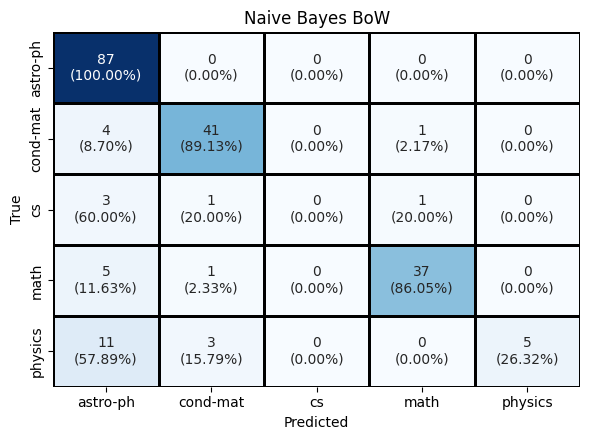

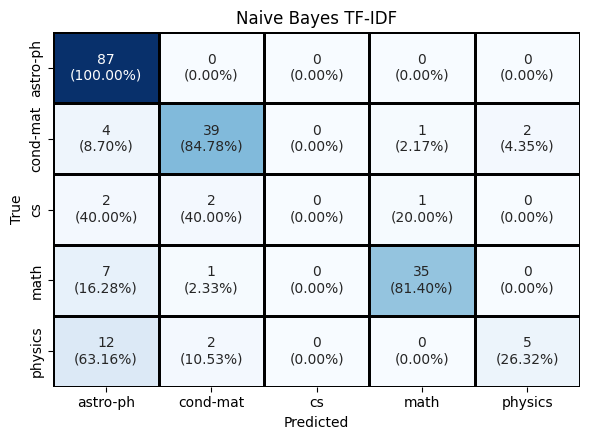

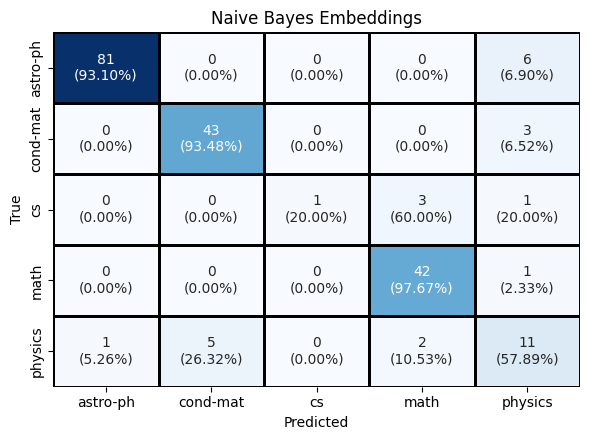

In [46]:
plot_confusion_matrix(ytest, nb_bow_labels, id_to_label, 'Naive Bayes BoW')
plot_confusion_matrix(ytest, nb_tfidf_labels, id_to_label, 'Naive Bayes TF-IDF')
plot_confusion_matrix(ytest, nb_embeddings_labels, id_to_label, 'Naive Bayes Embeddings')